## Script 2, Saloni Khandelwal
#### (Topic Detection, Article Filtering)
### Topic Detection: Latent Dirichlet Allocation (LDA)

In [ ]:
import pandas as pd
import pyarrow
import re

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize
nltk.download('punkt')

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import gensim.downloader as api

import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /Users/ankita7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ankita7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankita7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install textblob

In [ ]:
!pip install spacy

In [ ]:
!pip install pyLDAvis

  Using cached numpy-1.24.3-cp310-cp310-macosx_11_0_arm64.whl (13.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [ ]:
!pip install gensim

In [ ]:
import os
import time
import math
import re
from pprint import pprint
from textblob import TextBlob
import pandas as pd
import numpy as np


import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string


import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [ ]:
!pip install pandarallel

In [ ]:
!pip install progress

In [ ]:
from pandarallel import pandarallel
import multiprocessing
from progress.bar import Bar

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=Bar())

Available CPUs: 10
INFO: Pandarallel will run on 9 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
df = pd.read_parquet('preprocessed_news_final_1.parquet')
df.head()

,url,date,language,title,text,cleaned_text,important_words
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar...","Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019. As the city further deepens its roadside parking reform, the ETC system has almost covered all the roadside parking spaces in the city, with the proportion of vehicles parked on roads using the system exceeding 90 percent. With the AI-empowered system, drivers can park their vehicles at the parking spots on the roadside, and then pay the parking charge via their mobile phones after they dri...",urban areas city started use ETC system roadside parking spaces since July 1 2019 city deepens roadside parking reform ETC system almost covered roadside parking spaces city proportion vehicles parked roads using system exceeding 90 percent AIempowered system drivers park vehicles parking spots roadside pay parking charge via mobile phones drive away road used full cars even normal lanes occupied could hardly move bit morning evening commute time recalled citizen surnamed Wang lives Chaoyang...
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament Thursday, February 27, 2020 Latest: Mansplaining in conferences: How can we get him to forestall? The learn about noticed seven youngsters with gentle to average autism take domestic what’s referred to as a socially assistive robotic, named Kiwi, for a month. As Kiwi was once fitted with machine-learning era, it was once in a position to offer distinctive comments and directio...",Children Autism Saw Learning Social Skills Boosted Playing AI Robot News Parliament Thursday February 27 2020 Latest Mansplaining conferences get forestall learn noticed seven youngsters gentle average autism take domestic whats referred socially assistive robotic named Kiwi month Kiwi fitted machinelearning era position offer distinctive comments directions kids accordance talents example kid given query incorrect Kiwi would give activates assist resolve tweak trouble ranges problem kid cor...
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection

In [ ]:
df.shape

(140223, 7)

In [ ]:
%%time
df['important_words'] = df['important_words'].str.lower()
df['tokens'] = df['important_words'].apply(lambda x: nltk.word_tokenize(x))
data_tokens = df['tokens'].tolist()

CPU times: user 1min 49s, sys: 1.25 s, total: 1min 50s
Wall time: 1min 53s


In [ ]:
bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
# Create n-grams
data_words_bigrams = make_bigrams(data_tokens)
data_words_trigrams = make_trigrams(data_tokens)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_combined = data_words_trigrams

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 217.1 kB/s eta 0:00:0000:0100:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [ ]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index.
dictionary = corpora.Dictionary(data_tokens_combined)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_tokens_combined]

CPU times: user 57.5 s, sys: 2.02 s, total: 59.5 s
Wall time: 1min 2s


In [ ]:
workers = num_processors-1
workers

9

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_tokens_combined, dictionary=dictionary, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [ ]:
start_time = time.time()

def tic():
    global start_time
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60)
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [ ]:
%%time

grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
#alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')
alpha = ['symmetric'] # Run for number of topics only

# Beta parameter
#beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25),
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5),
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75),
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')


# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary,
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()

lda_tuning = pd.DataFrame(model_results)
#lda_tuning.to_csv(os.path.join(path_lda, 'lda_tuning_results.csv'), index=False)

LDA will execute 9 iterations
Completed model based on 2 LDA topics. Finished 11.1% of LDA runs
Execution time to calculate for topic 2: 0hour:3min:1sec
Completed model based on 3 LDA topics. Finished 22.2% of LDA runs
Execution time to calculate for topic 3: 0hour:3min:41sec
Completed model based on 4 LDA topics. Finished 33.3% of LDA runs
Execution time to calculate for topic 4: 0hour:4min:15sec
Completed model based on 5 LDA topics. Finished 44.4% of LDA runs
Execution time to calculate for topic 5: 0hour:5min:39sec
Completed model based on 6 LDA topics. Finished 55.6% of LDA runs
Execution time to calculate for topic 6: 0hour:7min:42sec
Completed model based on 7 LDA topics. Finished 66.7% of LDA runs
Execution time to calculate for topic 7: 0hour:15min:0sec
Completed model based on 8 LDA topics. Finished 77.8% of LDA runs
Execution time to calculate for topic 8: 0hour:22min:28sec
Completed model based on 9 LDA topics. Finished 88.9% of LDA runs
Execution time to calculate for topi

In [ ]:
lda_tuning_best = lda_tuning.sort_values(by=['Coherence'], ascending=False).head(1)


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()


try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()

print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 10, Alpha: symmetric, Beta: auto


In [ ]:
lda_tuning_best

,Topics,Alpha,Beta,Coherence
8,10,symmetric,auto,0.530143


**Best Parameters: Topics: 10

In [ ]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)

coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_tokens_combined,
                                     dictionary=dictionary, coherence='c_v')

CPU times: user 3min 43s, sys: 3min 56s, total: 7min 39s
Wall time: 1h 28min 10s


In [ ]:
# Print the Keyword in the best topic model
pprint(tuned_lda_model.print_topics())
doc_lda = tuned_lda_model[doc_term_matrix]

[(0,
  '0.010*"ai" + 0.005*"data" + 0.003*"technology" + 0.002*"said" + '
  '0.002*"also" + 0.002*"company" + 0.002*"new" + 0.002*"business" + '
  '0.002*"companies" + 0.002*"us"'),
 (1,
  '0.008*"ai" + 0.003*"said" + 0.003*"chatgpt" + 0.003*"one" + 0.002*"also" + '
  '0.002*"like" + 0.002*"new" + 0.002*"even" + 0.002*"use" + 0.002*"us"'),
 (2,
  '0.017*"market" + 0.004*"report" + 0.004*"market_report" + 0.003*"industry" '
  '+ 0.003*"data" + 0.003*"analysis" + 0.002*"market_research" + '
  '0.002*"market_size" + 0.002*"market_growth" + 0.002*"market_share"'),
 (3,
  '0.002*"ai" + 0.001*"please_enter_search_term" + 0.001*"242017_fsa" + '
  '0.001*"navigation_close_navigation_search" + '
  '0.001*"sponsored_toggle_menu_open" + 0.001*"said" + 0.001*"data" + '
  '0.001*"regulation_242017_fsa_regulation" + '
  '0.001*"may_published_broadcast_rewritten" + 0.001*"___"'),
 (4,
  '0.004*"ai" + 0.002*"said" + '
  '0.001*"visit_compareautoinsuranceorg_online_provider" + '
  '0.001*"life_home_hea

In [ ]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

/Users/ankita7/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


CPU times: user 1min 38s, sys: 4min 31s, total: 6min 10s
Wall time: 57.4 s


**Potential Topic List**

Topic 0: AI and Data

Topic 1: AI and ChatGPT

Topic 2: Market Analysis and Reports

Topic 3: Search Terms

Topic 4: AI and Insurance

Topic 5: AI in Air India

Topic 6: AI and Cryptocurrency Trades

Topic 7: AI in Business and Technology

Topic 8: AI and Information

Topic 9: AI and Social Media Moderation

Topic 0: AI in Business

AI's impact on data utilization and analysis in businesses
Technology-driven advancements in AI applications
The role of AI in transforming business operations and strategies
Companies leveraging AI to drive innovation and gain a competitive edge
Emerging trends in AI adoption by businesses across industries

Topic 1: AI and ChatGPT

Applications of AI-powered chatbots like ChatGPT
Enhancing user experience through AI-driven conversational agents
Exploring the capabilities and limitations of AI language models like ChatGPT
How AI chatbots are revolutionizing customer support and service interactions
Ethical considerations in the development and deployment of AI chat systems

Topic 2: Market Analysis and Research

Market reports and their role in analyzing industry trends and forecasts
Leveraging data analysis and market research for informed decision-making
The impact of market size and share on business strategies and competition
Key insights derived from market analysis and their significance for industries
Growth opportunities and challenges identified through market research

Topic 4: AI in the Insurance Industry

AI applications in automating insurance processes and enhancing customer experiences
AI-driven risk assessment and fraud detection in the insurance sector
Impact of AI on insurance pricing, underwriting, and claims management
Innovations in insurance technology powered by artificial intelligence
Challenges and ethical considerations in integrating AI into insurance practices

Topic 5: AI in Air India (Airlines)

Role of AI in enhancing operational efficiency and passenger experience in airlines
Adoption of AI technologies by Air India for various functions such as scheduling and maintenance
AI-driven advancements in airline safety and security measures
Utilizing AI to personalize services and improve customer satisfaction in the aviation industry
Opportunities and challenges in implementing AI solutions in the airline sector

Topic 9: Social Media Moderation and Spam Detection

Techniques and tools for detecting and combating spam on social media platforms
Ethical considerations in moderating user-generated content using AI
Ensuring compliance and privacy in social media content moderation

Filter Topic 3.

In [ ]:
df['topic'] = [sorted(doc, key=lambda x: x[1], reverse=True)[0][0] for doc in doc_lda]

In [ ]:
df.head()

,url,date,language,title,text,cleaned_text,important_words,tokens,topic
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar...","Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019. As the city further deepens its roadside parking reform, the ETC system has almost covered all the roadside parking spaces in the city, with the proportion of vehicles parked on roads using the system exceeding 90 percent. With the AI-empowered system, drivers can park their vehicles at the parking spots on the roadside, and then pay the parking charge via their mobile phones after they dri...",urban areas city started use etc system roadside parking spaces since july 1 2019 city deepens roadside parking reform etc system almost covered roadside parking spaces city proportion vehicles parked roads using system exceeding 90 percent aiempowered system drivers park vehicles parking spots roadside pay parking charge via mobile phones drive away road used full cars even normal lanes occupied could hardly move bit morning evening commute time recalled citizen surnamed wang lives chaoyang...,"[urban, areas, city, started, use, etc, system, roadside, parking, spaces, since, july, 1, 2019, city, deepens, roadside, parking, reform, etc, system, almost, covered, roadside, parking, spaces, city, proportion, vehicles, parked, roads, using, system, exceeding, 90, percent, aiempowered, system, drivers, park, vehicles, parking, spots, roadside, pay, parking, charge, via, mobile, phones, drive, away, road, used, full, cars, even, normal, lanes, occupied, could, hardly, move, bit, morning, ...",0
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament Thursday, February 27, 2020 Latest: Mansplaining in conferences: How can we get him to forestall? The learn about noticed seven youngsters with gentle to average autism take domestic what’s referred to as a socially assistive robotic, named Kiwi, for a month. As Kiwi was once fitted with machine-learning era, it was once in a position to offer distinctive comments and directio...",children autism saw learning social skills boosted playing ai robot news parliament thursday february 27 2020 latest mansplaining conferences get forestall learn noticed seven youngsters gentle average autism take domestic whats referred socially assistive robotic named kiwi month kiwi fitted machinelearning era position offer distinctive comments directions kids accordance talents example kid given query incorrect kiwi would give activates assist resolve tweak trouble ranges pr

/var/folders/1q/cr3dj0m115vf89fcxv59dk7r0000gn/T/ipykernel_57527/2176009844.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


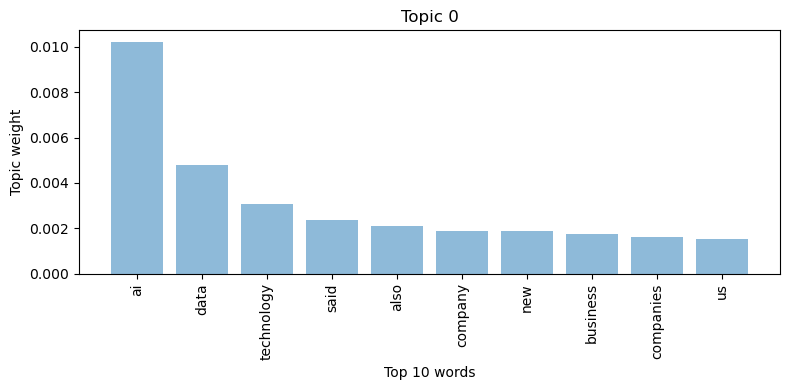

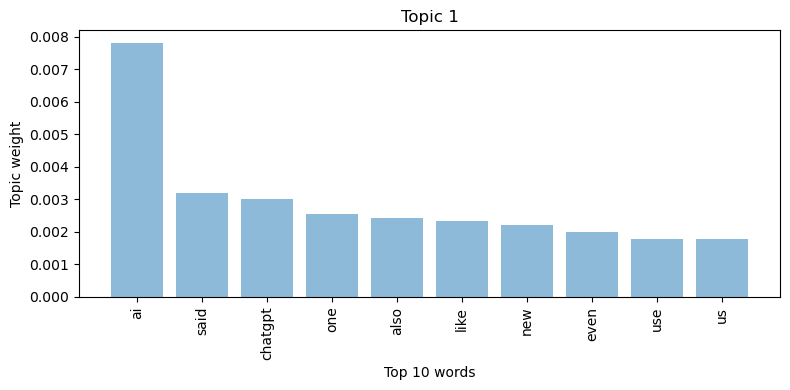

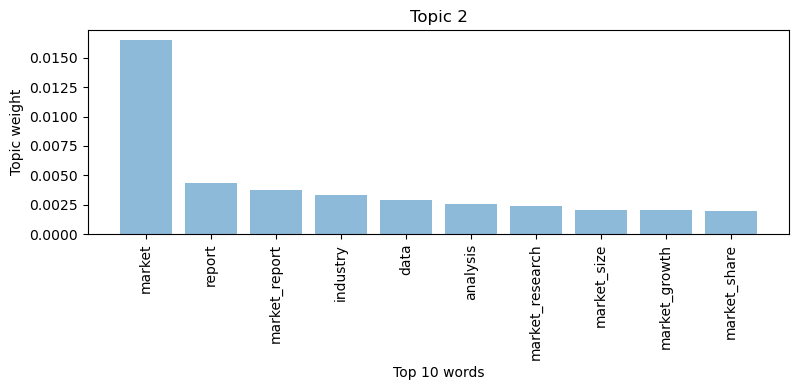

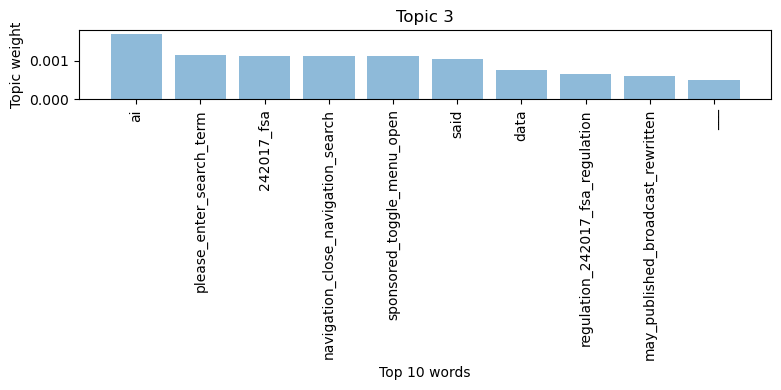

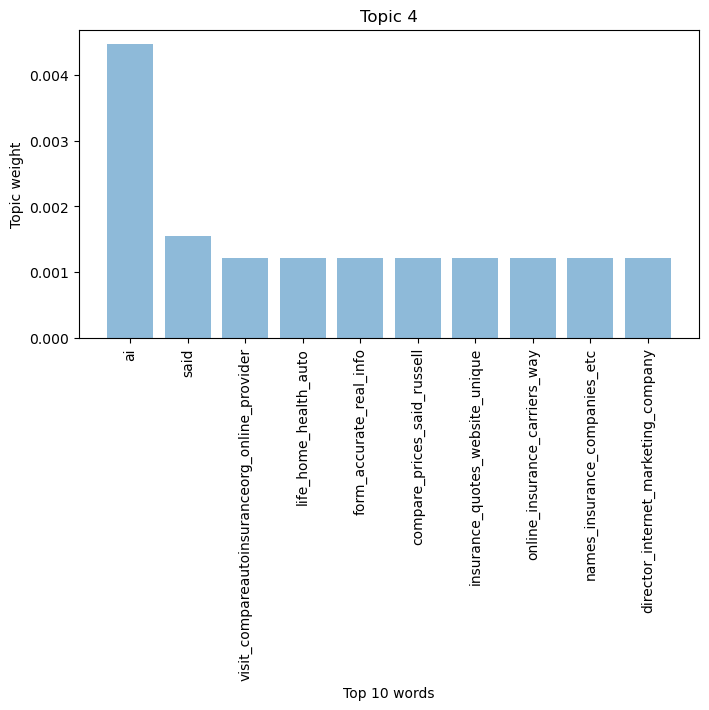

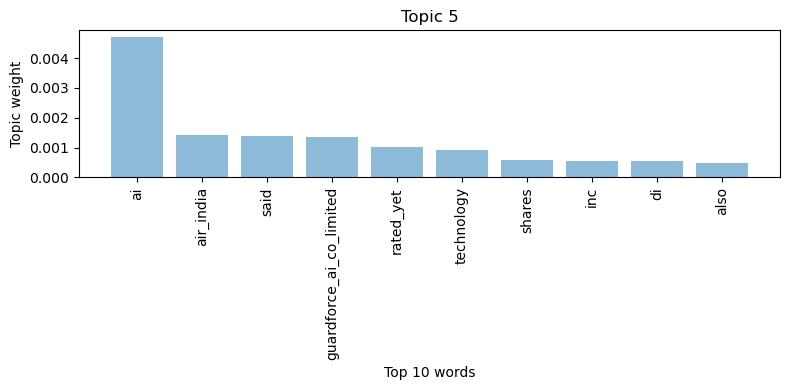

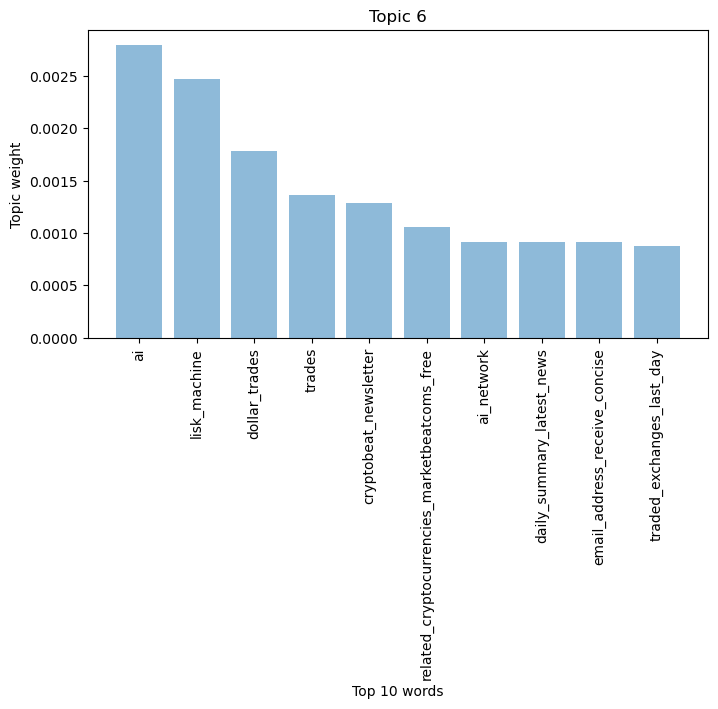

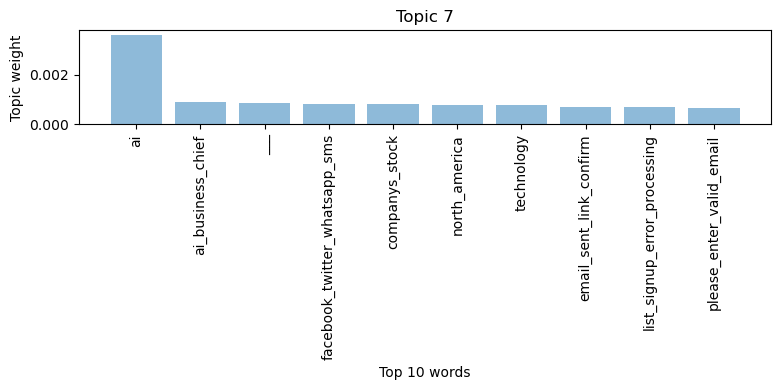

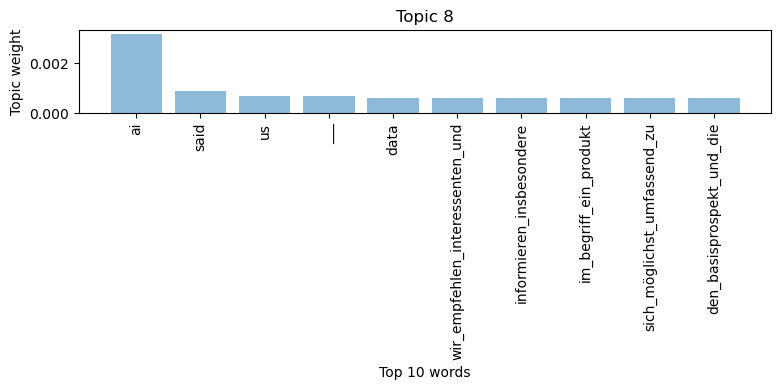

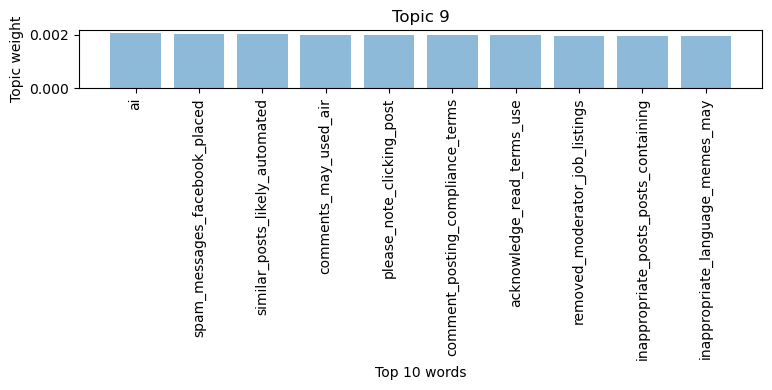

In [ ]:
top_words_per_topic = []
for i, topic in tuned_lda_model.show_topics(num_topics=-1, num_words=10, formatted=False):
    top_words_per_topic.append([word[0] for word in topic])

for i, topic in enumerate(top_words_per_topic):
    plt.figure(figsize=(8, 4))
    plt.bar([word for word in topic], [tuned_lda_model.get_topic_terms(i)[j][1] for j in range(10)], alpha=0.5)
    plt.title(f'Topic {i}')
    plt.xlabel('Top 10 words')
    plt.ylabel('Topic weight')
    plt.xticks(rotation=90)
    plt.tight_layout()

plt.show()

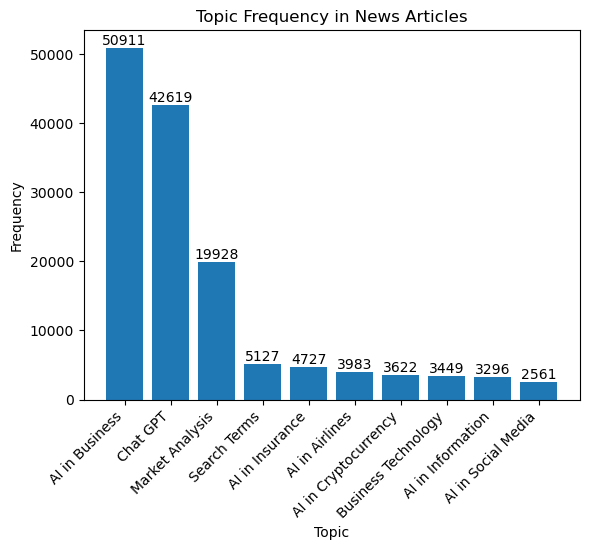

In [ ]:
assigned_topics = df['topic']

custom_labels = ['AI in Business', 'Chat GPT', 'Market Analysis', 'Search Terms', 'AI in Insurance',
                 'AI in Airlines', 'AI in Cryptocurrency', 'Business Technology', 'AI in Information', 'AI in Social Media']

topic_counts = assigned_topics.value_counts()

sorted_topics = topic_counts.sort_values(ascending=False)

topics = sorted_topics.index
frequencies = sorted_topics.values

plt.bar(range(len(topics)), frequencies, tick_label=custom_labels)
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Topic Frequency in News Articles')
plt.xticks(rotation=90)

for i, freq in enumerate(frequencies):
    plt.text(i, freq, str(freq), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')

plt.show()

### Article Filtering

In [ ]:
df[df['topic'] == 3]

,url,date,language,title,text,cleaned_text,important_words,tokens,topic
34,https://bisouv.com/uncategorized/3046922/global-hvac-software-market-report-2020-upkeep-technologies-synchroteam-ai-field-management-repairshopr-fieldez-technologies-westrom-software-astea-international-profit-rhino-thoughtful-syste/,2021-03-11,en,"Global HVAC Software Market Report 2020: UpKeep Technologies, Synchroteam, Ai Field Management, RepairShopr, FieldEZ Technologies, Westrom Software, Astea International, Profit Rhino, Thoughtful Systems, mHelpDesk, etc. – The Bisouv Network","\n\nGlobal HVAC Software Market Report 2020: UpKeep Technologies, Synchroteam, Ai Field Management, RepairShopr, FieldEZ Technologies, Westrom Software, Astea International, Profit Rhino, Thoughtful Systems, mHelpDesk, etc. – The Bisouv Network\n\nSkip to the content\n\n \nSearch\nThe Bisouv Network\n\n \nMenu\n\nEnergy\nEntertainment\nFashion\nPolitics\nSports\nAll News\nWorld\nContact\n\n Search\nSearch for:\nClose search\n \nClose Menu\n \n\n\nEnergy\nEntertainment\nFashion\nPolitics\nSpo...","Global HVAC Software Market Report 2020: UpKeep Technologies, Synchroteam, Ai Field Management, RepairShopr, FieldEZ Technologies, Westrom Software, Astea International, Profit Rhino, Thoughtful Systems, mHelpDesk, etc. Post author By anita_adroit Post date March 11, 2021 Introduction and ScopeThe research report on global HVAC Software market provides insightful data about market and all the important aspects related to it. The pattern in the HVAC Software industry gives an absolute overvie...",global hvac software market report 2020 upkeep technologies synchroteam ai field management repairshopr fieldez technologies westrom software astea international profit rhino thoughtful systems mhelpdesk etc post author anita_adroit post date march 11 2021 introduction scopethe research report global hvac software market provides insightful data market important aspects related pattern hvac software industry gives absolute overview prime players weightlessness product definition company summ...,"[global, hvac, software, market, report, 2020, upkeep, technologies, synchroteam, ai, field, management, repairshopr, fieldez, technologies, westrom, software, astea, international, profit, rhino, thoughtful, systems, mhelpdesk, etc, post, author, anita_adroit, post, date, march, 11, 2021, introduction, scopethe, research, report, global, hvac, software, market, provides, insightful, data, market, important, aspects, related, pattern, hvac, software, industry, gives, absolute, overview, prim...",3
94,https://fox40.com/news/border-report/border-patrol-adds-artificial-intelligence-cameras-to-security-arsenal/,2022-03-26,en,Border Patrol adds artificial intelligence cameras to security arsenal,\n\n \n\nBorder Patrol adds artificial intelligence cameras to security arsenal\nSkip to content\n\n\nFOX40\nSacramento\n\n67°\nSacramento\n\n67°\n\nSponsored By\n\n \nToggle Menu\n\n\nOpen Navigation\nClose Navigation\n\nSearch\n\nPlease enter a search term.\nPrimary Menu\n\nNews\nLocal News\nCalifornia\nWildfire Watch\nCoronavirus\nRussia and Ukraine Conflict\nInside California Politics\nPolitics\nNational and World News\nLive Traffic Updates\nConversations for Change\nSacramento’s Remarka...,"Border Patrol adds artificial intelligence cameras to security arsenal FOX40 Sacramento 67° Sacramento 67° Sponsored By Toggle Menu Open Navigation Close Navigation Search Please enter a search term. An agent instructed her to remove filthy camouflage pants and shirt while an interpreter inside the Border Patrol station questioned her in Spanish. “Before they abandoned you, where did they tell you to go?” he asked as she removed two of the three layers of clothing she wore. “They told you to...",border patrol adds artificial intelligence cameras security arsenal fox40 sacramento 67 sacramento 67 sponsored toggle menu open navigation close navigation search please enter search term agent instructed remove filthy camoufl

In [ ]:
df.shape

(140223, 9)

In [ ]:
filtered_df = df[df['topic'] != 3]
filtered_df.head()

,url,date,language,title,text,cleaned_text,important_words,tokens,topic
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar...","Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019. As the city further deepens its roadside parking reform, the ETC system has almost covered all the roadside parking spaces in the city, with the proportion of vehicles parked on roads using the system exceeding 90 percent. With the AI-empowered system, drivers can park their vehicles at the parking spots on the roadside, and then pay the parking charge via their mobile phones after they dri...",urban areas city started use etc system roadside parking spaces since july 1 2019 city deepens roadside parking reform etc system almost covered roadside parking spaces city proportion vehicles parked roads using system exceeding 90 percent aiempowered system drivers park vehicles parking spots roadside pay parking charge via mobile phones drive away road used full cars even normal lanes occupied could hardly move bit morning evening commute time recalled citizen surnamed wang lives chaoyang...,"[urban, areas, city, started, use, etc, system, roadside, parking, spaces, since, july, 1, 2019, city, deepens, roadside, parking, reform, etc, system, almost, covered, roadside, parking, spaces, city, proportion, vehicles, parked, roads, using, system, exceeding, 90, percent, aiempowered, system, drivers, park, vehicles, parking, spots, roadside, pay, parking, charge, via, mobile, phones, drive, away, road, used, full, cars, even, normal, lanes, occupied, could, hardly, move, bit, morning, ...",0
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament Thursday, February 27, 2020 Latest: Mansplaining in conferences: How can we get him to forestall? The learn about noticed seven youngsters with gentle to average autism take domestic what’s referred to as a socially assistive robotic, named Kiwi, for a month. As Kiwi was once fitted with machine-learning era, it was once in a position to offer distinctive comments and directio...",children autism saw learning social skills boosted playing ai robot news parliament thursday february 27 2020 latest mansplaining conferences get forestall learn noticed seven youngsters gentle average autism take domestic whats referred socially assistive robotic named kiwi month kiwi fitted machinelearning era position offer distinctive comments directions kids accordance talents example kid given query incorrect kiwi would give activates assist resolve tweak trouble ranges pr

In [ ]:
filtered_df.shape

(136927, 9)

In [ ]:
filtered_df.to_parquet('filtered_news.parquet')